In [1]:
import pickle
import numpy as np
import scipy.io as sio
import yaml

In [ ]:
"""
======================================
FEM simulation with distributed loads
- no control/drivers
- 10 seconds simulation (2kHz)
- influence matrix from stiffness
- old_consolidated model
======================================
"""

movie_name = "old_consolidated_influence_matrix.mp4"

displacements_ptt = pickle.load( open( './logs/displacements_ptt.sclogs',
                                       "rb" ) )['displacements_ptt']

bending_modes = pickle.load( open( './logs/bending_modes.sclogs',
                                   "rb" ) )['bending_modes']

transformation_path = '../database/bendingmodes/STBM_transformation_matrices_f.mat'

Q_seg = np.squeeze(sio.loadmat(transformation_path)['Q_incell'])
U_seg = np.squeeze(sio.loadmat(transformation_path)['U_incell'])

In [89]:
def remove_ptt_time(seg_displacements_ptt, Q, vartype = np.float64):
    n_samples = seg_displacements_ptt.shape[1]
    n_nodes = seg_displacements_ptt.shape[0]

    displacements_noptt_ = np.empty([n_nodes, n_samples], dtype=vartype)
    ptt = np.empty([n_nodes, n_samples], dtype=vartype)
    
    for k in range(displacements_noptt_.shape[1]):
        _aux = np.linalg.lstsq(Q, seg_displacements_ptt[:,k])[0]
        ptt[:,k] = np.dot(Q, _aux)
        displacements_noptt_[:,k] = seg_displacements_ptt[:,k] - ptt[:,k]
    return displacements_noptt_, ptt

def disp_to_bm(disp_noPTT, U):
    U64 = np.empty(U.shape, dtype=np.float64)
    disp_noPTT64 = np.empty(disp_noPTT.shape, dtype=np.float64)
    
    U64[:] = U[:]
    disp_noPTT64[:] = disp_noPTT[:]
    
    return np.dot(U64.T, disp_noPTT64) # returns bm

def bm_to_disp(bm, U):
    return np.dot(U, bm) 


import matplotlib.pyplot as plt
import matplotlib.tri as mtri   
import matplotlib.animation as animation
import matplotlib as mpl
import scipy.spatial as ssp
try:
    from jupyterthemes import jtplot
    jtplot.style()
except:
    pass


def init_surface(Q):
    resolution = 1000
    tri = ssp.Delaunay(Q[:,[0,1]])
    xi = Q[:,0]
    yi = Q[:,1]
    triang = mtri.Triangulation(xi, yi, tri.simplices.copy())
    
    xi = np.linspace(xi.min(), xi.max(), resolution)
    yi = np.linspace(yi.min(), yi.max(), resolution)
    xii, yii = np.meshgrid(xi, yi)
    return [xii, yii, triang]

def return_surface(z, zmin, zmax, ax, xii, yii, triang):
        
    interp_cubic_geom = mtri.CubicTriInterpolator(triang, z, kind='geom')
    zi_cubic_geom = interp_cubic_geom(xii, yii)
    graph = ax.contourf(xii, yii, zi_cubic_geom, vmin = zmin, vmax = zmax)
    
    
    return graph

In [57]:
# Remove PTT


ptt = np.empty((7,), dtype = object)
disp_noPTT = np.empty((7,), dtype = object)

for seg in range(7):
    disp_noPTT[seg], ptt[seg] = remove_ptt_time(displacements_ptt[seg],
                                                Q_seg[seg],
                                               vartype = np.float64)
    
    # Recover displacements from bending modes

rec_disp = np.empty((7,), dtype = object)

for seg in range(7):
    rec_disp[seg] = bm_to_disp(bending_modes[seg], U_seg[seg][:,:-3])

/home/felipe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


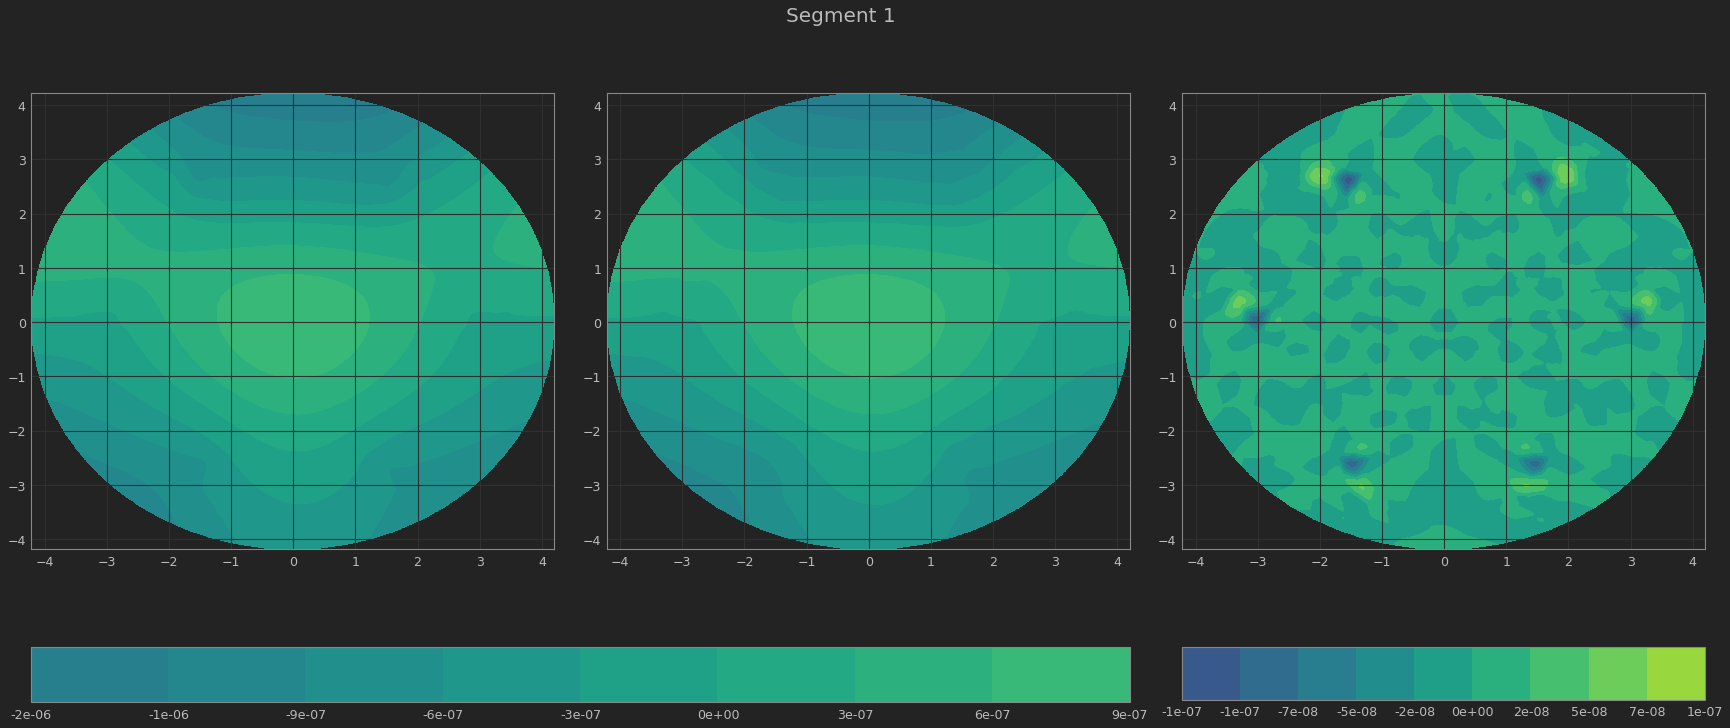

In [156]:
Ts  = 100
seg = 0
Q_ = Q_seg[seg]

fig, axes =  plt.subplots(1 ,3 ,figsize = (30, 12))
plt.subplots_adjust(hspace=.0, wspace=0.1)
ax1, ax2, ax3 = axes

z_max = np.amax(rec_disp[seg])
z_min = np.amin(rec_disp[seg])
z_step = (z_max - z_min)/10

error = disp_noPTT[seg] - rec_disp[seg]
e_max = np.amax(error)
e_min = np.amin(error)

xii, yii, triang = init_surface(Q_)

z_org_, z_rec_, error_ = disp_noPTT[seg][:, k], rec_disp[seg][:,k], error[:,k]

graph1 = return_surface(z_org_, z_min, z_max, ax1, xii, yii, triang)
graph2 = return_surface(z_rec_, z_min, z_max, ax2, xii, yii, triang)
graph3 = return_surface(error_, e_min, e_max, ax3, xii, yii, triang)

cbar1 = fig.colorbar(graph1, ax = [ax1, ax2], orientation='horizontal', aspect=20,
                     format='%.0e')

cbar2 = fig.colorbar(graph3, ax=[ax3], orientation='horizontal', aspect=10,
                     format='%.0e')

fig.suptitle('Segment ' + str(seg + 1), fontsize=20);

# Animation

In [140]:
seg = 0

duration = 10
fps = 40

frame_sampling = 2000/fps
frame_interval = 1/fps * 1000 #ms

50.0

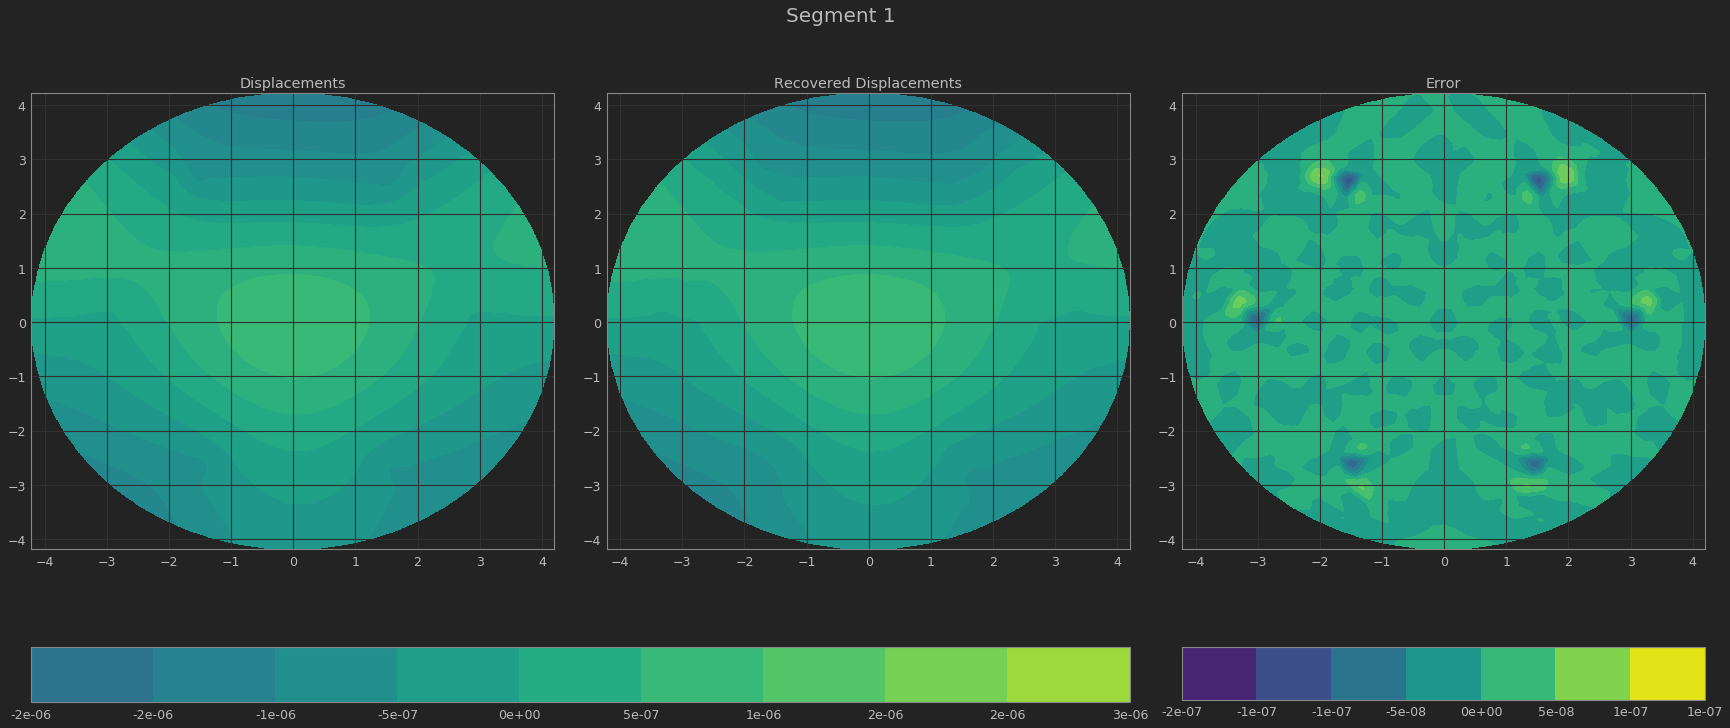

In [138]:
z_org = disp_noPTT[seg]
z_rec = rec_disp[seg]
error = z_org - z_rec

z_max  = np.amax([z_org, z_rec])
z_min  = np.amin([z_org, z_rec])

Q_ = Q_seg[seg]

xii, yii, tiang = init_surface(Q_)

fig, axes =  plt.subplots(1 ,3 ,figsize = (30, 12))
plt.subplots_adjust(hspace=.0, wspace=0.1)
ax1, ax2, ax3 = axes
ax1.set_title('Displacements')
ax2.set_title('Recovered Displacements')
ax3.set_title('Error')
_motion = list()

fig.suptitle('Segment ' + str(seg + 1), fontsize=20);

for k in range(0, duration * 2000 + 1, frame_sampling):
    z_org_, z_rec_, error_ = z_org[:, k], z_rec[:,k], error[:,k]
    _image1 = return_surface(z_org_,  z_min, z_max, ax1, xii, yii, triang)
    _image2 = return_surface(z_rec_,  z_min, z_max, ax2, xii, yii, triang)
    _image3 = return_surface(error_,  e_min, e_max, ax3, xii, yii, triang)
    _motion.append(_image1.collections + _image2.collections + _image3.collections)
    
cbar1 = fig.colorbar(graph1, ax = [ax1, ax2], orientation='horizontal', aspect=20,
                 format='%.0e')
cbar2 = fig.colorbar(graph3, ax=[ax3], orientation='horizontal', aspect=10,
                 format='%.0e')

graph1.set_clim(vmin = z_min, vmax = z_max)
graph3.set_clim(vmin = e_min, vmax = e_max)

print(len(_motion))

In [145]:
ani = animation.ArtistAnimation(fig, _motion,
                                interval = frame_interval,
                                repeat = False, 
                                blit = False)
ani.save("./movies/" + movie_name, writer='ffmpeg')